In [31]:
################################
# Gerekli Kütüphanleri Çağırma #
################################
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)

################################
# Veri Setini Çağırma ve Keşif #
################################
df = pd.read_csv("C:/Users/guikf/OneDrive/Masaüstü/data sets/creditcard.csv")

def research(dataframe,target):
    print("Veri Setinin Boyutu")
    print(f"{dataframe.shape}\n")
    print(f"{target} Değişkenine Göre Veri Dağılımı")
    print(f"{dataframe[target].value_counts()} \n")
    print(dataframe[target].value_counts(normalize=True) * 100)
research(df,"Class")

Veri Setinin Boyutu
(284807, 31)

Class Değişkenine Göre Veri Dağılımı
0    284315
1       492
Name: Class, dtype: int64 

0    99.827251
1     0.172749
Name: Class, dtype: float64


In [32]:
 ####################################################################################################################
# Veri Setini Bölme ( Çok fazla 'Class = 0' durumu var overfittingi önlemek ve sonradan modeli değerlendirmek için) #
 ####################################################################################################################

validation = df[df["Class"] == 0]
validation = validation.sample(n=100000, random_state=43)

df = df.drop(validation.index)
print(df.shape)

(184807, 31)


Accuracy Skor: 0.999112592528462 
 Roc/Auc Eğrisi Alanı: 0.9817308704998978 
 Hata Matriksi: 
 [[46080    38]
 [    3    81]]
       Value Feature
14  0.681170     V14
10  0.107780     V10
7   0.053835      V7
12  0.046901     V12
17  0.028154     V17
8   0.007510      V8
3   0.006201      V3
26  0.006185     V26
21  0.005285     V21
4   0.005205      V4
22  0.005099     V22
2   0.005098      V2
6   0.004720      V6
16  0.004326     V16
27  0.003909     V27
11  0.003890     V11
9   0.003597      V9
18  0.002744     V18
15  0.002257     V15
25  0.002174     V25
20  0.001825     V20
0   0.001816    Time
24  0.001761     V24
29  0.001745  Amount
5   0.001419      V5
19  0.001413     V19
13  0.001149     V13
28  0.001117     V28
23  0.000993     V23
1   0.000726      V1


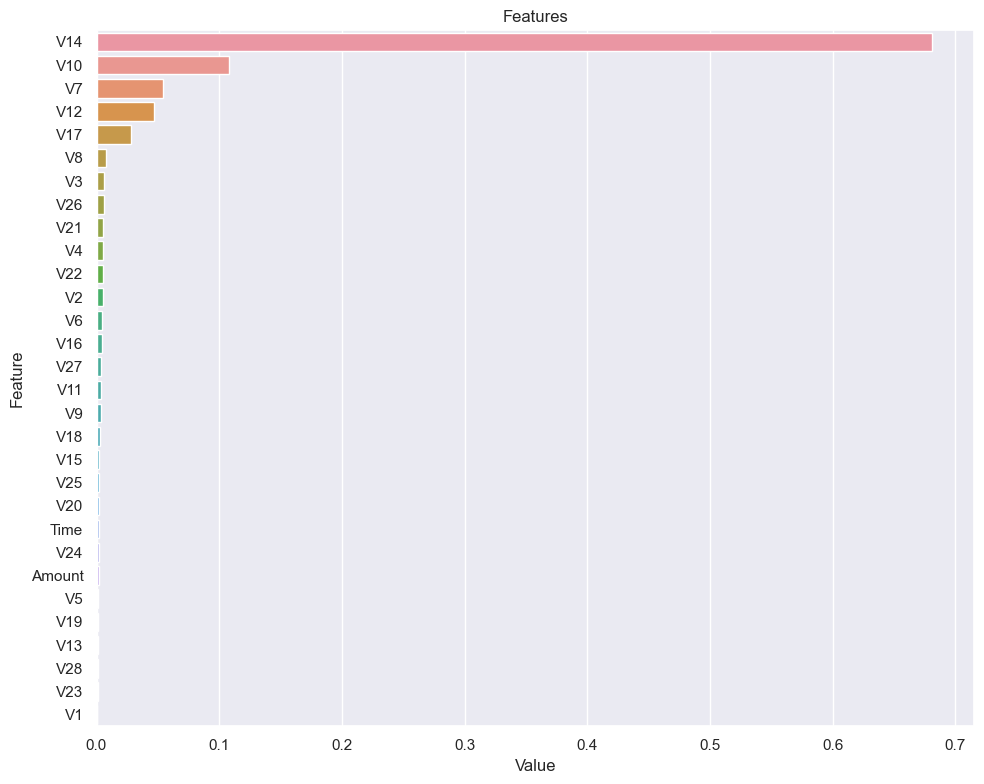

In [45]:
 #################################################################################################################
# XGBoost'la Modelleme - (İşlemci Üstünden Veriyi İşleme Aldığı için Büyük Hacimli Verileri Hızlı Sonuçlandırır  #
 #################################################################################################################

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split

Y = df["Class"]
X = df.drop("Class",axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.25,random_state=43)
XGB = XGBClassifier(random_state=43,max_depth=6, eta=0.01,eval_metric="logloss").fit(X_train,Y_train)
y_prediction = XGB.predict(X_test)

Old_Accuracy = accuracy_score(y_prediction,Y_test)
Old_Roc_Auc = roc_auc_score(y_prediction,Y_test)
Old_hata = confusion_matrix(y_prediction,Y_test)

print(f"Accuracy Skor: {Old_Accuracy} \n Roc/Auc Eğrisi Alanı: {Old_Roc_Auc} \n Hata Matriksi: \n {Old_hata}")

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(XGB,X)

In [34]:
##################################################
# Değişken Önemliliği %1'den Fazla Olanların Seçimi #
##################################################

feature_imp = pd.DataFrame({'Value': XGB.feature_importances_, 'Feature': X.columns})
asc_feature = feature_imp.sort_values("Value", ascending=False)

def feature_importance_select(dataframe):
    High = []
    for v, f in dataframe.values:
        if v > 0.01:
            print(f"{f.upper()} = {v}")
            High.append(f)

    return High

improve_ = feature_importance_select(asc_feature)
improve_.append("Time")
improve_.append("Amount")
improve = df[improve_]


V14 = 0.6811695098876953
V10 = 0.10777977108955383
V7 = 0.05383497104048729
V12 = 0.04690094664692879
V17 = 0.028153546154499054


Eski Accuracy: 0.999112592528462 - Accuracy: 0.9992641011211636 
Eski Roc/Auc Değeri: 0.9817308704998978 - Roc/Auc Değeri: 0.981657 
Eski Hata Matriksi: 
 [[46080    38]
 [    3    81]] 
 Hata Matriksi: 
 [[46061    30]
 [    4   107]]
      Value Feature
0  0.794775     V14
1  0.095135     V10
3  0.058821     V12
4  0.026384     V17
2  0.013855      V7
6  0.007984  Amount
5  0.003046    Time


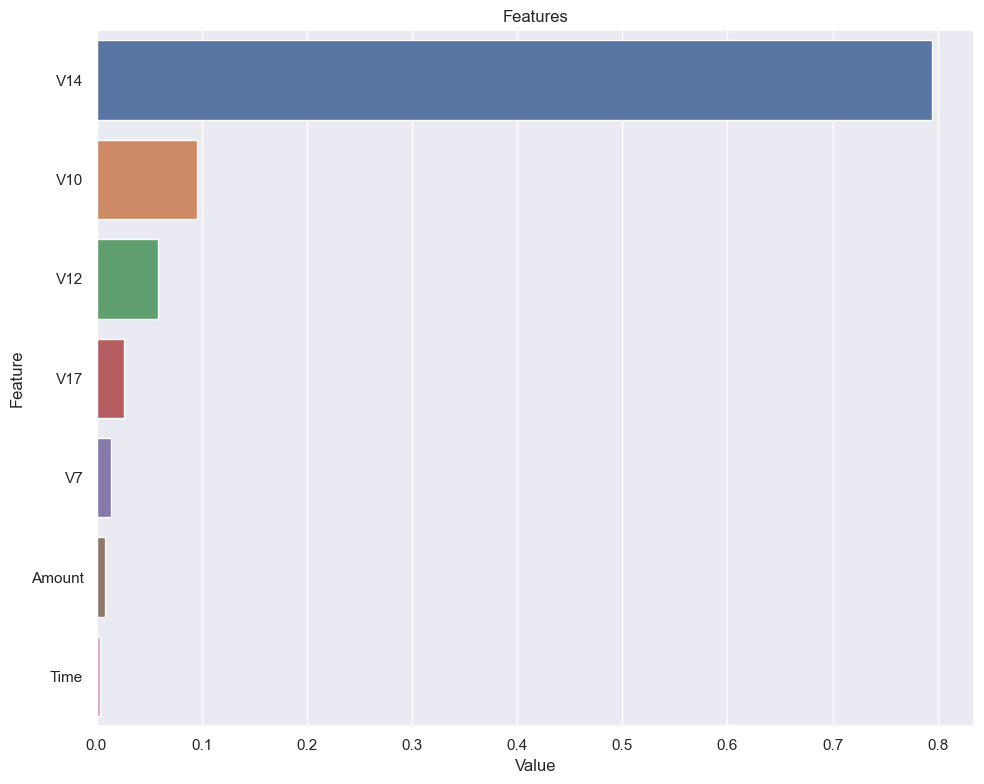

In [46]:
##########################################################################################
# XGBoost Modelinin Önemlilik Düzeyi %1'den Fazla Olan Değişkenlerle Yeniden Uygulanması #
##########################################################################################

X_train, X_test, Y_train, Y_test = train_test_split(improve,Y, test_size=0.25,random_state=41)
XGB = XGBClassifier(random_state=43,max_depth=6, eta=0.01,eval_metric="logloss").fit(X_train,Y_train)
y_prediction = XGB.predict(X_test)

print(f"Eski Accuracy: {Old_Accuracy} - Accuracy: {accuracy_score(y_prediction,Y_test)} \n"
      f"Eski Roc/Auc Değeri: {Old_Roc_Auc} - Roc/Auc Değeri: {round(roc_auc_score(y_prediction,Y_test),6)} \n"
      f"Eski Hata Matriksi: \n {Old_hata} \n Hata Matriksi: \n {confusion_matrix(y_prediction,Y_test)}")


plot_importance(XGB,improve)

In [55]:
##########################################################################################
# Bekletilen Veri Seti Olan yani 'Class = 0' Eşit Olan Durumlar için Modelin Uygulanması #
##########################################################################################
validation = validation[['V14', 'V10', 'V7', 'V12', 'V17',"Time","Amount"]]
validation.head()

# Modelli Uygulama #
y_prediction_validation = XGB.predict(validation)
y_prediction_validation[0:5]

validation_df = pd.DataFrame(y_prediction_validation,columns=["Pred"])
validation_df.head()
validation["Pred"] = y_prediction_validation
validation.head()


,V14,V10,V7,V12,V17,Time,Amount,Pred
242695,-0.342205,1.489036,-0.392536,-0.525843,0.136215,151604.0,25.00,0
26588,-0.479785,-0.149790,-0.520311,-0.597172,-0.226116,34155.0,168.30,0
275059,-0.045050,0.914577,-1.203288,-0.959434,-0.368983,166348.0,69.99,0
226202,-0.506424,1.554259,-1.216110,-0.844797,0.432756,144534.0,18.60,0
179584,-2.138679,-0.173660,0.997670,0.468273,0.517921,124145.0,34.66,0


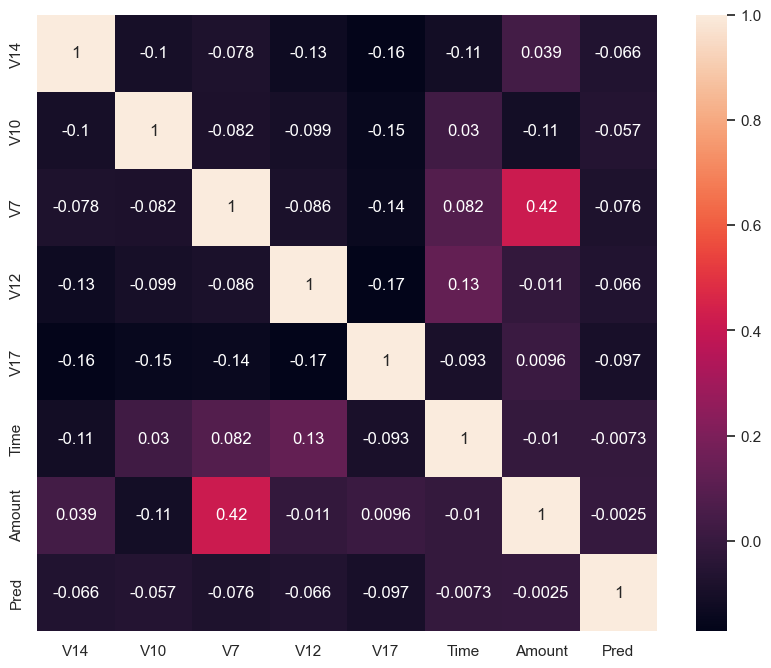

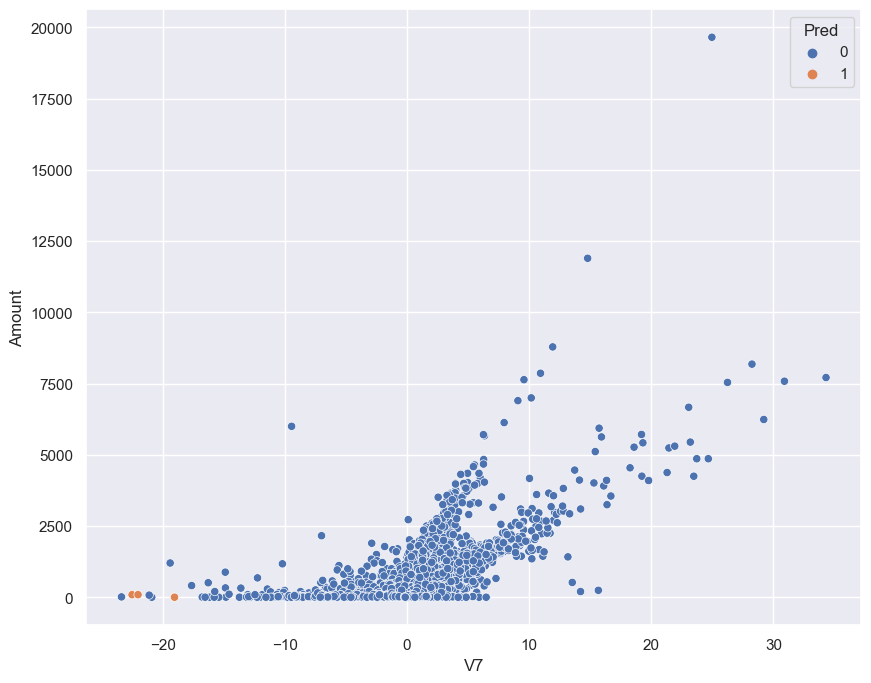

In [56]:
####################################################
# Oluşturulan Modelle İlgili Daha Detaylı Çıktılar #
####################################################
def corr(dataframe):
    plt.figure(figsize=(10, 8))
    sns.heatmap(dataframe.corr(), annot=True)
    plt.show()
    return dataframe.corr()

corr(validation)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=validation, x="V7",y="Amount",hue="Pred")
plt.show()

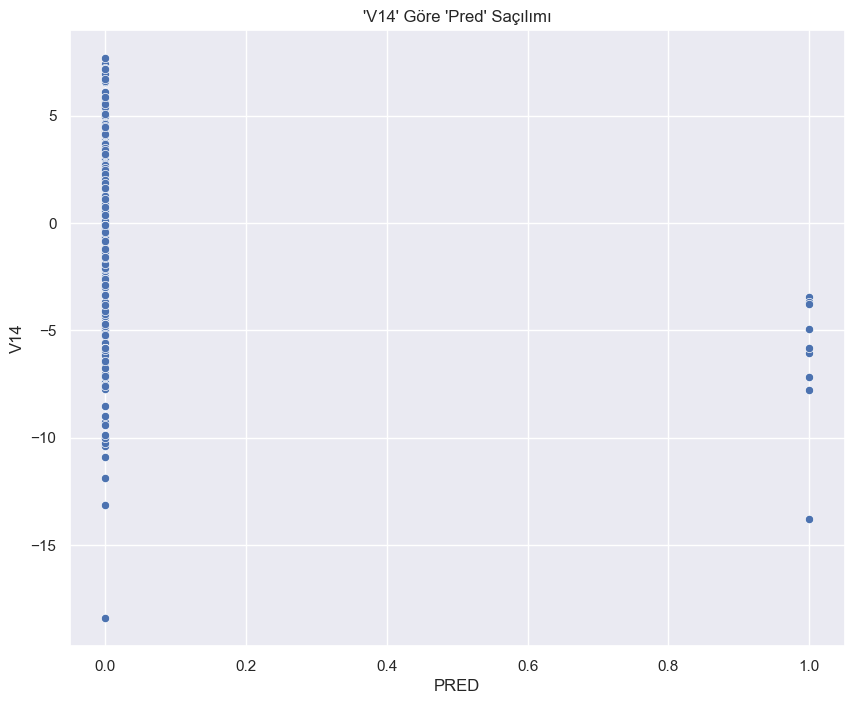

############### V14 Değişkenine Göre ############### 
           V14                               
          mean       std        min       max
Pred                                         
0     0.010080  0.893743 -18.392091  7.667726
1    -6.267447  3.208733 -13.780377 -3.427917




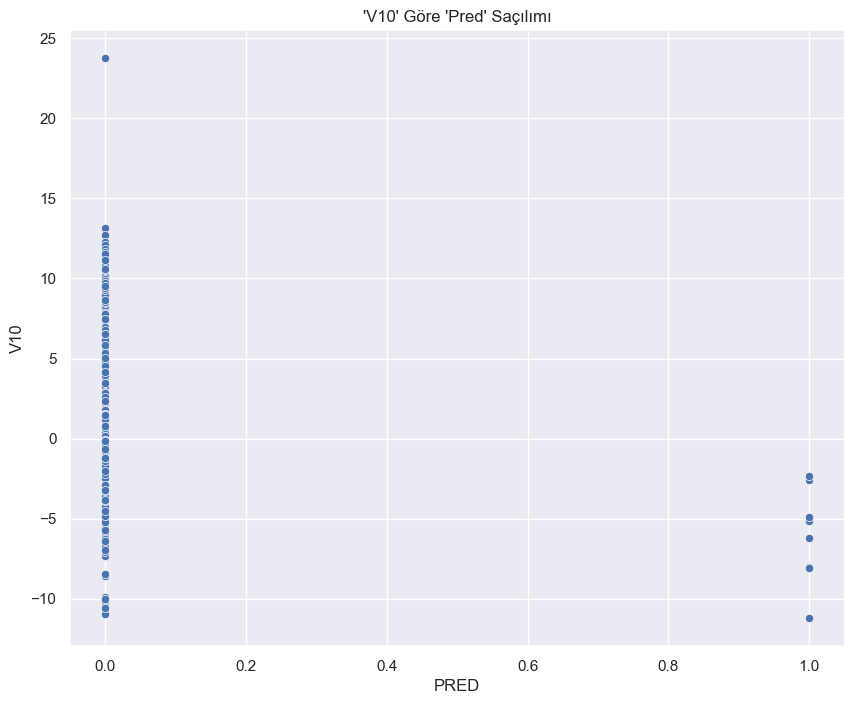

############### V10 Değişkenine Göre ############### 
           V10                                
          mean       std        min        max
Pred                                          
0     0.008554  1.036971 -10.957551  23.745136
1    -6.282238  2.883172 -11.208723  -2.332002




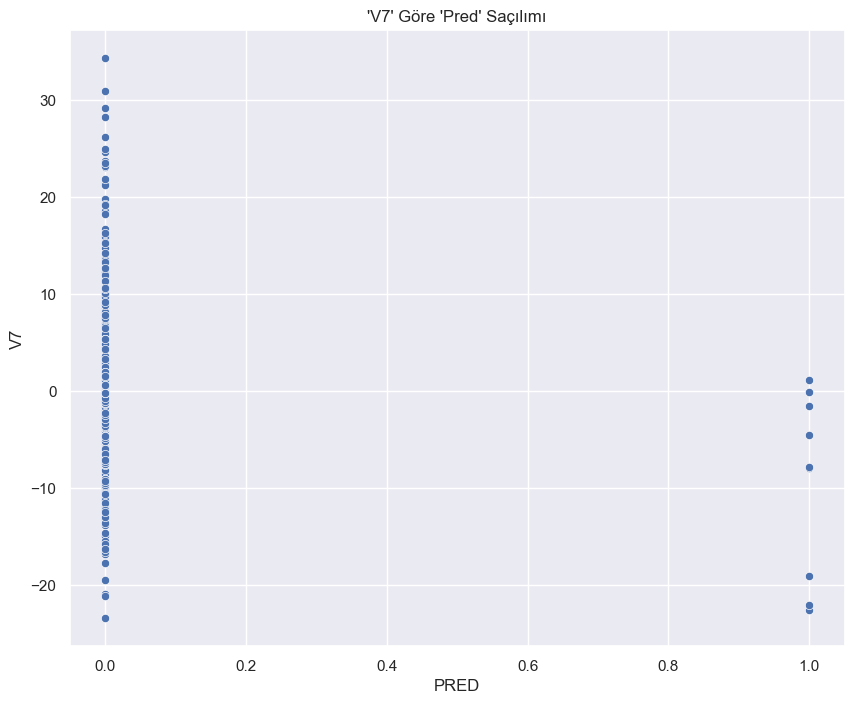

############### V7 Değişkenine Göre ############### 
            V7                                
          mean       std        min        max
Pred                                          
0     0.012219  1.170676 -23.386192  34.303177
1    -9.362926  9.448492 -22.518547   1.203394




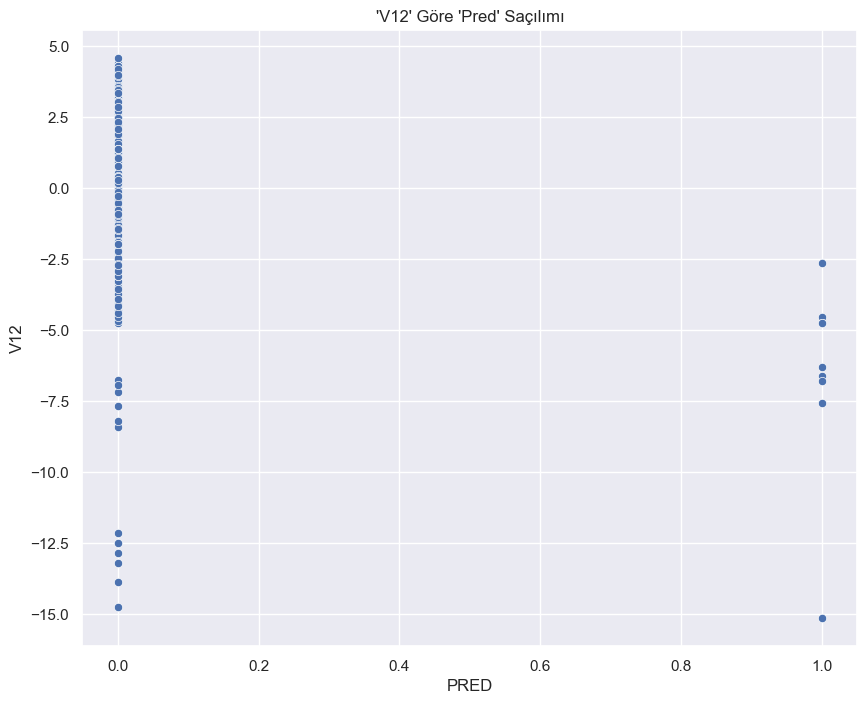

############### V12 Değişkenine Göre ############### 
           V12                               
          mean       std        min       max
Pred                                         
0     0.009237  0.944358 -14.745849  4.574082
1    -6.571953  3.547347 -15.144988 -2.651618




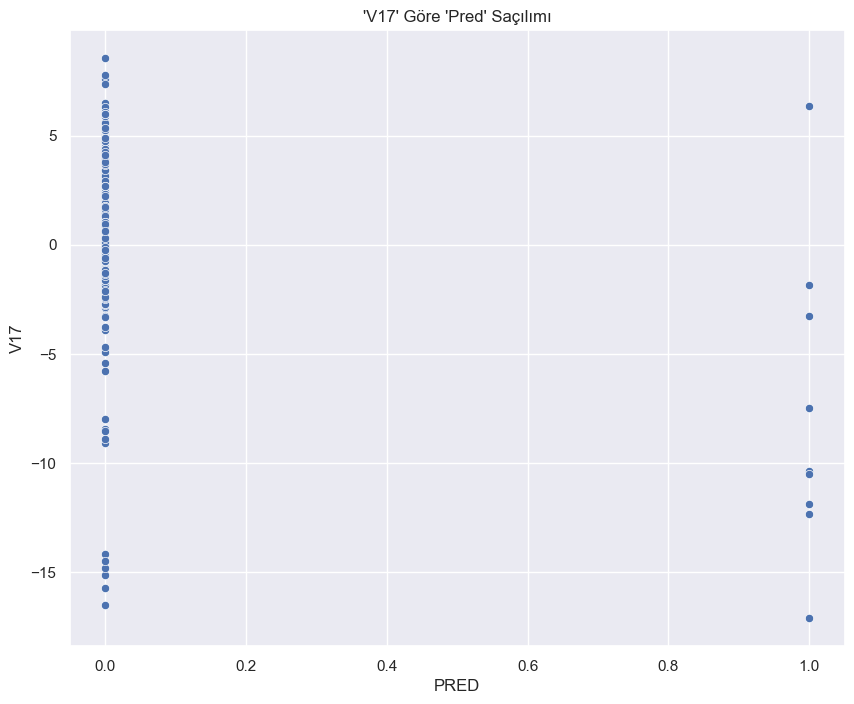

############### V17 Değişkenine Göre ############### 
           V17                               
          mean       std        min       max
Pred                                         
0     0.011789  0.739578 -16.511143  8.538195
1    -7.603115  7.013557 -17.098444  6.351413




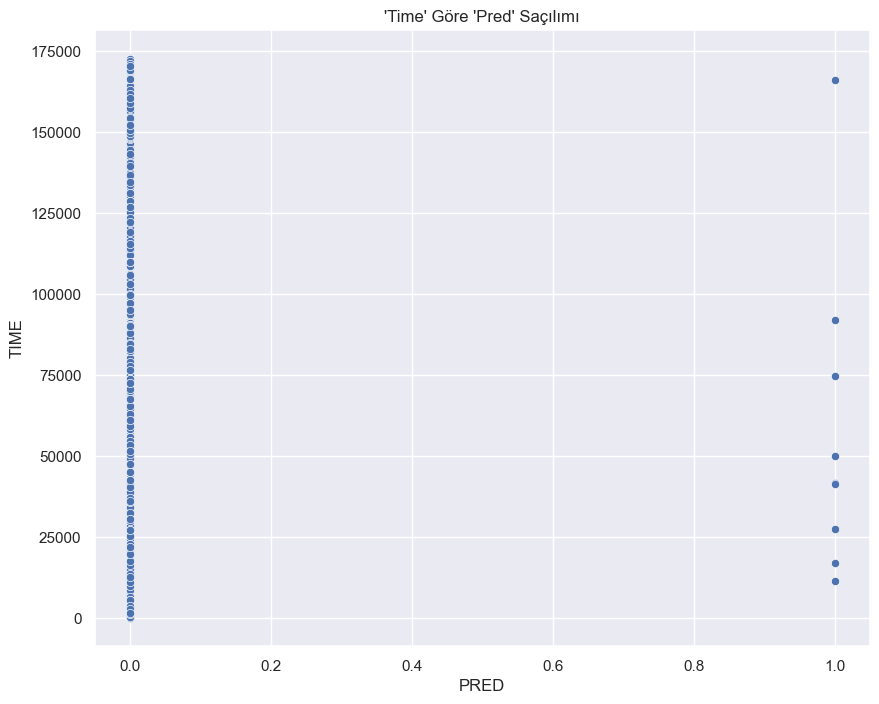

############### TIME Değişkenine Göre ############### 
              Time                                 
              mean           std      min       max
Pred                                               
0     94814.530968  47561.138988      1.0  172792.0
1     58018.888889  48064.348426  11347.0  166023.0




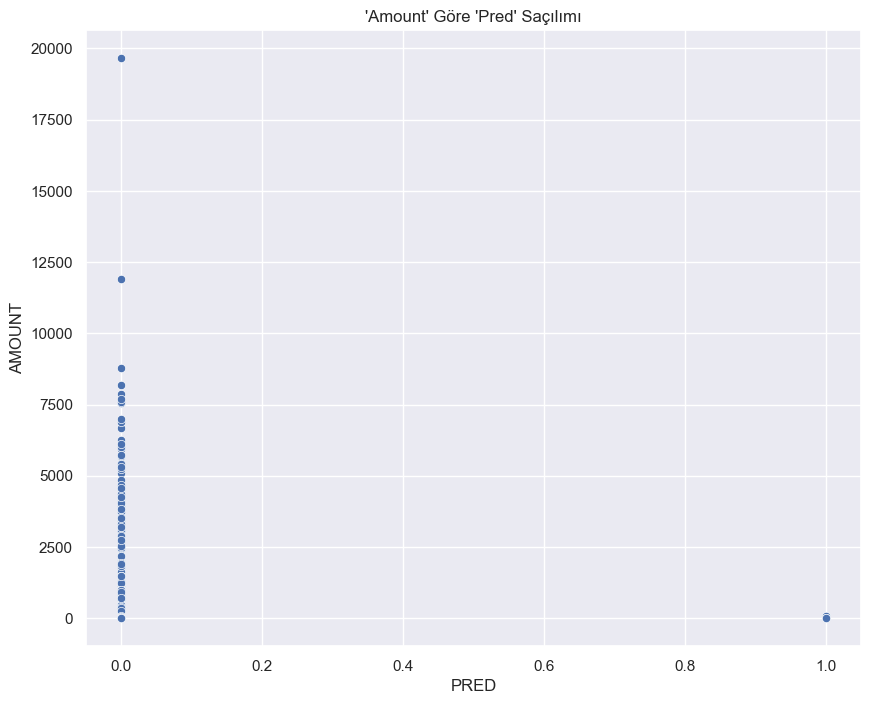

############### AMOUNT Değişkenine Göre ############### 
        Amount                           
          mean         std  min       max
Pred                                     
0     89.27072  252.393052  0.0  19656.53
1     22.11000   38.649016  1.0     89.99


########## PRED Değişkenin Değerlerinin Oranlanması #############
0    0.99991
1    0.00009
Name: Pred, dtype: float64


In [64]:
def classifier_outputs(dataframe,target):
    val = [col for col in dataframe.columns if col != target]
    for col in val:
        plt.figure(figsize=(10, 8))
        sns.scatterplot(data=dataframe, x=target, y=col)
        plt.title(f"'{col}' Göre '{target}' Saçılımı")
        plt.xlabel(f"{target.upper()}")
        plt.ylabel(f"{col.upper()}")
        plt.show()

        print(f"############### {col.upper()} Değişkenine Göre ############### ")
        print(dataframe.groupby(target).agg({col: ["mean", "std", "min", "max"]}))
        print("\n")

    print(f"########## {target.upper()} Değişkenin Değerlerinin Oranlanması #############")
    print(dataframe[target].value_counts(normalize=True))

classifier_outputs(dataframe=validation,target="Pred")